<a href="https://colab.research.google.com/github/AgusDelga2/NLP_tweets_periodismo/blob/main/twitter_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías


Las librerías utilizadas en este código son:

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Importamos de google drive
import io       # Para tener acceso a los archivos
import os       # Para usar los directorios
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Datos



In [ ]:
# Lectura de datos
# ==============================================================================
#Creamos ruta
url = '/content/drive/MyDrive/tweets_periodismo_NLP/Dataset/'
tweets_infobae = pd.read_csv(url + "tweets_infobae.csv")
tweets_filonews  = pd.read_csv(url + "tweets_filonews.csv")

print('Número de tweets @filonewsOK: ' + str(tweets_filonews.shape[0]))
print('Número de tweets @infobae: ' + str(tweets_infobae.shape[0]))

Número de tweets @filonewsOK: 200
Número de tweets @infobae: 200


In [ ]:
# Se unen los dos dataframes en uno solo
tweets = pd.concat([tweets_infobae, tweets_filonews], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
tweets = tweets[['Time', 'User', 'Tweet', 'ID']]
tweets.columns = ['fecha', 'autor', 'texto', 'id']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

print(tweets)

                        fecha       autor  \
0   2022-11-03 15:44:10+00:00     infobae   
1   2022-11-03 15:41:33+00:00     infobae   
2   2022-11-03 15:41:32+00:00     infobae   
3   2022-11-03 15:38:09+00:00     infobae   
4   2022-11-03 15:36:40+00:00     infobae   
..                        ...         ...   
395 2022-11-01 15:05:17+00:00  filonewsOK   
396 2022-11-01 15:04:18+00:00  filonewsOK   
397 2022-11-01 15:03:19+00:00  filonewsOK   
398 2022-11-01 15:02:09+00:00  filonewsOK   
399 2022-11-01 14:20:49+00:00  filonewsOK   

                                                 texto                   id  
0    El llanto del Chacho Coudet tras ser despedido...  1588195336350318593  
1    Kanye West lo hizo otra vez: convenció a Adida...  1588194679820017666  
2    Registrate gratis en “Dinero” y recibí las nov...  1588194675298533378  
3    Griselda Siciliani protagonista de “Bardo”, el...  1588193824538492929  
4    25 fotos: el lanzamiento de la Semana de la Co...  1588193449345

###Limpieza y Tokenización


La función limpiar_tokenizar() elimina el símbolo @ y # de las palabras a las que acompañan. En Twitter, los usuarios se identifican de esta forma, por lo que @ y # pertenecen al nombre.

In [ ]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = tweets.texto[0]
print(test)
print(limpiar_tokenizar(texto=test))

El llanto del Chacho Coudet tras ser despedido del Celta de Vigo: “Es la primera vez que me dan de baja” https://t.co/ldT6BZ14Bw
['el', 'llanto', 'del', 'chacho', 'coudet', 'tras', 'ser', 'despedido', 'del', 'celta', 'de', 'vigo', '“es', 'la', 'primera', 'vez', 'que', 'me', 'dan', 'de', 'baja”']


In [ ]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,El llanto del Chacho Coudet tras ser despedido...,"[el, llanto, del, chacho, coudet, tras, ser, d..."
1,Kanye West lo hizo otra vez: convenció a Adida...,"[kanye, west, lo, hizo, otra, vez, convenció, ..."
2,Registrate gratis en “Dinero” y recibí las nov...,"[registrate, gratis, en, “dinero”, recibí, las..."
3,"Griselda Siciliani protagonista de “Bardo”, el...","[griselda, siciliani, protagonista, de, “bardo..."
4,25 fotos: el lanzamiento de la Semana de la Co...,"[fotos, el, lanzamiento, de, la, semana, de, l..."


Cada elemento de la columna texto_tokenizado es una lista que contiene los tokens generados.

##Análisis exploratorio

A continuación estudiaremos qué palabra emplea cada medio, con qué frecuencia y el significado de las mismas.

In [ ]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,fecha,autor,id,token
0,2022-11-03 15:44:10+00:00,infobae,1588195336350318593,el
0,2022-11-03 15:44:10+00:00,infobae,1588195336350318593,llanto
0,2022-11-03 15:44:10+00:00,infobae,1588195336350318593,del


#### Frecuencia de palabras

In [ ]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
filonewsOK    4514
infobae       3273
Name: token, dtype: int64

In [ ]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
filonewsOK    1899
infobae       1464
Name: token, dtype: int64

Podemos observar que FiloNews en la misma cantidad de tweets (200) utiliza más palabras totales y a su vez emplea más palabras únicas.

### Longitud media de los tweets

In [ ]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
filonewsOK,22.570,8.742267
infobae,16.365,4.315657


El tipo de tweet de FiloNews es más largo, pero también alterna más que Infobae entre tweets cortos y largos, siendo mayor la desviación de Filonews

### 10 Palabras más utilizadas de cada medio

In [ ]:
# Top palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(10))

autor token  count
autor                                   
filonewsOK 403   filonewsOK    de    319
           955   filonewsOK    la    208
           554   filonewsOK    en    144
           534   filonewsOK    el    143
           1419  filonewsOK   que    122
           1015  filonewsOK   los     71
           420   filonewsOK   del     63
           1558  filonewsOK    se     58
           1330  filonewsOK   por     56
           1734  filonewsOK    un     55
infobae    2251     infobae    de    227
           2648     infobae    la    145
           2353     infobae    el    109
           2374     infobae    en    103
           2952     infobae   por     86
           3003     infobae   que     74
           3239     infobae    un     59
           2263     infobae   del     52
           2689     infobae   los     43
           2876     infobae  para     35

###Stop words


En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords.

In [ ]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [ ]:
# Obtención de listado de stopwords en español
# ==============================================================================
stop_words = list(stopwords.words('spanish'))
# Se añaden preposiciones a la stoprword: cómo, 
stop_words.extend(("bajo", "cabe", "con", "contra", "de", "desde", "durante", "en", "entre", "hacia", "hasta", "mediante", "para", "por", "según", "sin", "sobre", "tras", "versus"))
print(stop_words[:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


In [ ]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

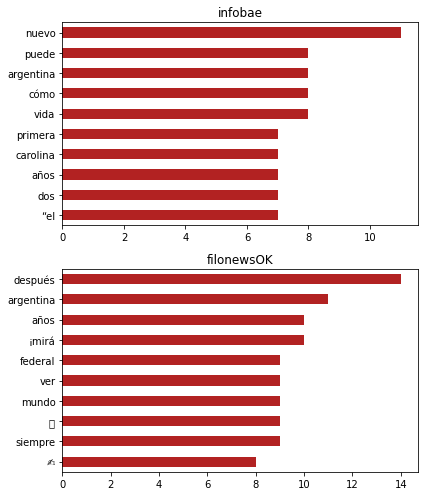

In [ ]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

###Correlación entre autores

In [ ]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [ ]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,filonewsOK,infobae
filonewsOK,1.000000,0.759199
infobae,0.759199,1.000000


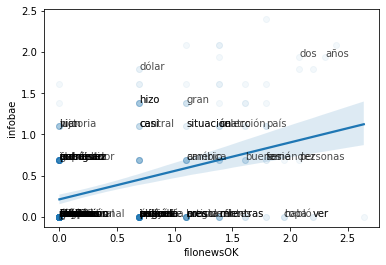

In [ ]:
# Gráfico de correlación
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.filonewsOK),
    y  = np.log(temp.infobae),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.filonewsOK[i]), np.log(temp.infobae[i])),
         alpha = 0.7
        )